# Pet Insurance Customer Segmentation - EDA

## 1 Introduction

### 1.1 Background
The Marketing department at a leading pet insurance provider is seeking to better understand its customer base to prevent customer loss and drive additional company revenue. Data suggests that customers are most likely to cancel their policies around the 2-year point following enrollment.   

### 1.2 Project Goal
The goal of this project is to identify 3-4 customer segments (with come justification for each) that will enable the Marketing team reduce customer shrinkage while improving outcomes related to targeted ads and/or direct-to-customer campaigns. 

Initial data suggests some key features that may be helpful for clustering include:
* Pet species (cat or dog)
* Amount of claims (in year 1, in year 2 and total)
* Number of claims (in year 1, in year 2 and total)
* Highest claim amount over the 2 year period
* Pet age

### 1.3 Data for EDA
During data wrangling, the PetData.csv and ClaimData.csv files were reviewed, cleaned and merged into a single dataset, merged_pets.csv.

### 1.4 Questions for EDA
The following is a list of some of the initial next steps identified for EDA based on the analysis completed during data wrangling.
* What relationships exist between some of the key features mentioned by the marketing team?
    * Pet species (cat or dog)
    * Amount of claims (in year 1, in year 2 and total)
    * Number of claims (in year 1, in year 2 and total)
    * Highest claim amount
    * Pet age
* Are there other features that look to be important in terms of clustering the customer base?

## 2 Setup

### 2.1 Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### 2.2 Data Load & Preview

In [2]:
# Read in the data file generated during data wrangling
pets = pd.read_csv('../data/merged_pets.csv')

# Preview
pets.head(7).T

,0,1,2,3,4,5,6
PetId,0,1,2,3,4,5,6
Species,Dog,Dog,Dog,Dog,Dog,Dog,Cat
Breed,Schnauzer Standard,Yorkiepoo,Mixed Breed Medium,Labrador Retriever,French Bulldog,Shih Tzu,American Shorthair
Premium,84.54,50.33,74.0,57.54,60.69,43.53,47.4
Deductible,200,500,500,500,700,700,250
EnrollPath,Web,Phone,Phone,Phone,Web,Phone,Web
AgeYr1,3,0,0,0,0,2,0
MixedBreed,0,0,1,0,0,0,0
AmtClaimsYr1,0.0,0.0,640.63,0.0,7212.25,2665.67,0.0
AmtClaimsYr2,1242.0,0.0,1187.68,0.0,168.75,0.0,811.38


In [3]:
pets.shape

(50000, 18)

### 2.3 Data Wrangling Summary 
Before we get started on the analysis, let's take a moment to recap what we've learned so far and what the data looks like.

#### 2.3.1 What do we know? 
* **Shape** - Our clean dataframe is 50000 rows with each row corresponding to a single pet.
* **Basic Info** - For each pet, we have some basic info including species, breed, age at time of enrollment and enroll path.
* **Policy Info** - We also have policy-level info for each pet including the monthly premium and deductible amount for claims.
* **Claims Data** - We also have claims data for each pet covering the first two policy years including:
    * Number of claims per year and total (years 1 and 2 combined)
    * Average claim amount per year and total (years 1 and 2 combined) 
    * Amount of claims per year and total (years 1 and 2 combined)

#### 2.3.2 Initial Observations
* **Species** - We have two species of pets, Cats and Dogs
* **Breed** - We have 373 unique breeds in total (55 cat and 318 dog)
* **Age** - The age range is between 0 (i.e., < 1 year) and 13
* **Premium** - Premiums fall into a wide range with a few outlier values close to \\$1000
* **Deductible** - Deductibles are fairly well distributed and appear to be stratified across a range of common values.
* **Claims** 
    * For cats and dogs, the median value for total number and total amount of claims is 0.
    * On the flip side, both species have some significant outliers in both categories (number and amount of claims)
    
Now that we have a bit more context, let's jump in to the analysis.

## 3 Data Analysis

### 3.1 What is the count of pets per species?

In [4]:
pets.Species.value_counts()

Dog    41976
Cat     8024
Name: Species, dtype: int64

As observed in data wrangling, we have approximately 50,000 pets in our data, roughly 85% of which are dogs. The remaining 15% are cats, so that keeps things fairly simple as we only have two breeds to consider. 

### 3.2 How do species compare in terms of total claims amounts?

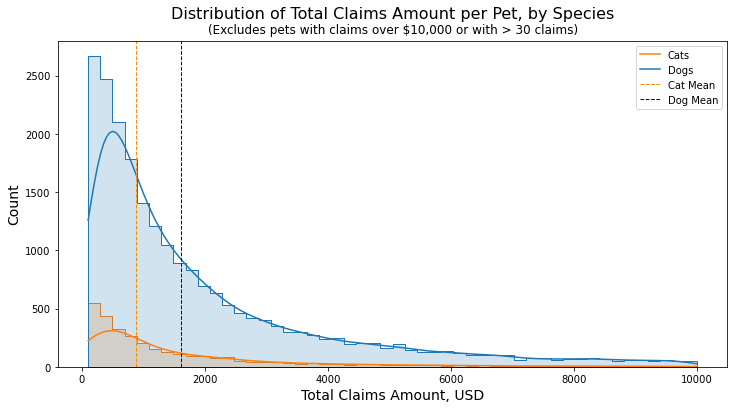

In [5]:
# Filter out outliers for number of claims and claim amounts
claim_filter = pets[(pets.AmtClaimsTotal < 10000) & (pets.AmtClaimsTotal > 100) &
                 (pets.NumClaimsTotal < 30) & (pets.NumClaimsTotal > 0)]

# Calculate mean values
dog_mean = pets[pets.Species == 'Dog']['AmtClaimsTotal'].mean()
cat_mean = pets[pets.Species == 'Cat']['AmtClaimsTotal'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

sns.histplot(x="AmtClaimsTotal", data=claim_filter, hue="Species", alpha=0.2,
             element='step', bins=50, kde=True)

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)

# Add title and display plot
plt.title("Distribution of Total Claims Amount per Pet, by Species", y=1.05, fontsize=16)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Total Claims Amount, USD", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cats', 'Dogs', 'Cat Mean', 'Dog Mean']), loc='upper right')
plt.savefig('../figures/Total-Claims-by-Species.png')
plt.show()

We see in the distribution above that dogs tend to have higher total claims over the first 2 policy years compared to cats. Next, let's take a look at the raw averages with outliers included to see if it shows a similar difference.

In [6]:
print("Dogs - Avg Total Claims: " + str(int(round(pets[pets.Species == 'Dog']['AmtClaimsTotal'].mean(),0))))
print("Cats - Avg Total Claims: " + str(int(round(pets[pets.Species == 'Cat']['AmtClaimsTotal'].mean(),0))))

Dogs - Avg Total Claims: 1606
Cats - Avg Total Claims: 877


Looking at the average total claims amounts for cats and dogs with outliers included, we see that **the average total claims for dogs is nearly 2x greater than the average total claims for cats.**

This seems to be somewhat significant and likely to be a factor when segmenting our customer base later on. Next, let's see if the same holds true for the total number of claims per pet.

### 3.3 Do dog owners submit more claims than cat owners?

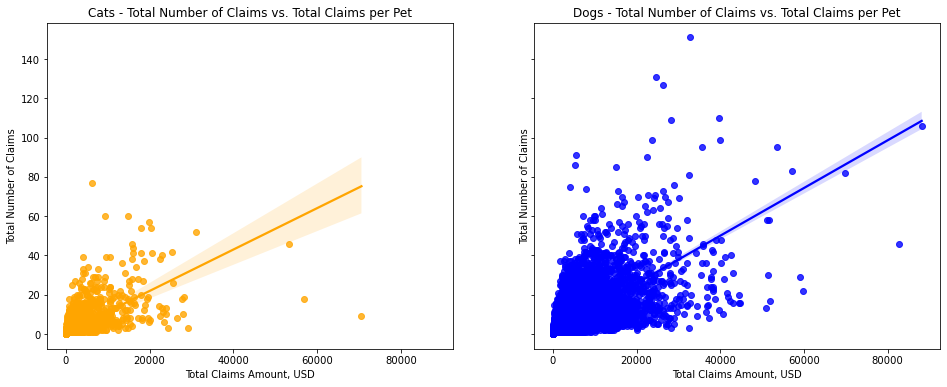

In [7]:
# Create regplots showing number of claims vs total claims amount by species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=True)
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=pets[pets.Species == 'Cat'], ax=ax1,
            color="Orange").set(title="Cats - Total Number of Claims vs. Total Claims per Pet",
                                xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")
sns.regplot(x="AmtClaimsTotal", y="NumClaimsTotal", data=pets[pets.Species == 'Dog'], ax=ax2,
            color="Blue").set(title="Dogs - Total Number of Claims vs. Total Claims per Pet", 
                              xlabel="Total Claims Amount, USD", ylabel="Total Number of Claims")

plt.show()

In the plot above, we see very similar patterns in terms of the number and amount of claims between species. Generally though, it does appear cat owners tend to submit fewer claims than dog owners. Let's take a look at the distributions for a closer look. Again, we'll apply the claim filter to make the distribution more interpretable.

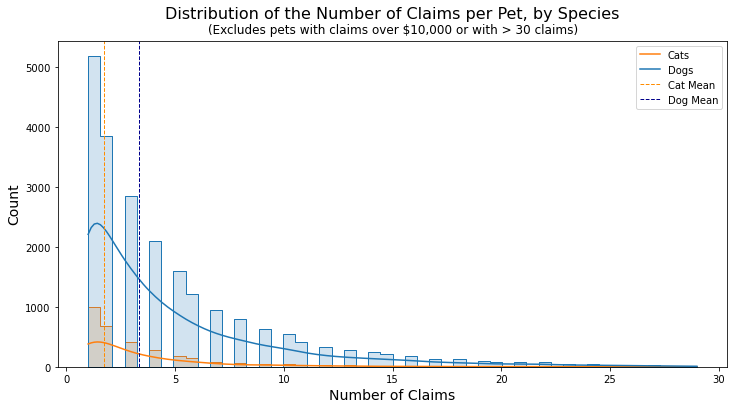

In [8]:
# Calculate mean values
dog_mean = pets[pets.Species == 'Dog']['NumClaimsTotal'].mean()
cat_mean = pets[pets.Species == 'Cat']['NumClaimsTotal'].mean()

# Create a histogram showing premium amounts by species
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.histplot(x="NumClaimsTotal", data=claim_filter, hue="Species", alpha=0.2,
             element='step', bins=50, kde=True)

# Plot mean premium amount for dogs and cats
plt.axvline(cat_mean, color='darkorange', linestyle='dashed', linewidth=1)
plt.axvline(dog_mean, color='darkblue', linestyle='dashed', linewidth=1)

# Add title and display plot
plt.title("Distribution of the Number of Claims per Pet, by Species", y=1.05, fontsize=16)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.92, x=0.513, fontsize=12)
plt.xlabel("Number of Claims", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.legend(labels=(['Cats', 'Dogs', 'Cat Mean', 'Dog Mean']), loc='upper right')
plt.savefig('../figures/Number-Claims-by-Species.png')
plt.show()

Looking at the distributions of number of claims for each species, we see that both are heavily right skewed. This plot also makes it easier to see the difference in terms of the average number of claims by species. Unsurprisingly, dog owners do tend to submit a greater number of claims on average when compared with cat owners over the 2 year span. 

### 3.4 How many pets have claims in one or both years?
We've seen that generally speaking, dogs tend to have more claims than cats. And during data wrangling, we observed that a significant number of pets have no claims at all within the first two years. 

**But what trends do we see for pets with claims in one or both years?** 
* Do the majority have claims in both years or only one year? 
* Additionally, are there any patterns that jump out when we look at pets with claims in both years in terms of species or age?

First, let's create a basic function to determine for each pet, if they have no claims, claims in one year (either year 1 or year 2), or claims in both years. Then we can plot our results to see if anything interesting jumps out.

In [9]:
# Create function to populate new column as count of number of years with claims (0, 1, 2)
def claim_yrs(row):
    if (row["NumClaimsTotal"] == 0):
        return 0
    elif ((row["NumClaimsYr1"] > 0) & (row["NumClaimsYr2"] > 0)):
        return 2
    else:
        return 1

# Apply function to df to create new column
pets["YrsWithClaims"] = pets.apply(claim_yrs, axis=1)

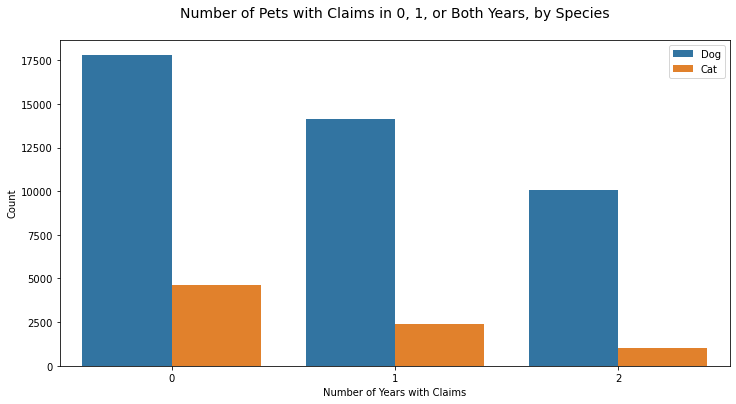

In [10]:
# Plot the count of pets with claims in 0, 1 or both years
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
palette ={"Dog": "#1f77b4", "Cat": "#ff7f0e"}
sns.countplot(x='YrsWithClaims', data=pets, hue="Species", palette=palette).set(ylabel="Count",
                                                             xlabel="Number of Years with Claims")

# Add title and display plot
plt.title("Number of Pets with Claims in 0, 1, or Both Years, by Species", y=1.05, fontsize=14)
plt.legend(loc='upper right')
plt.show()

As noted earlier, the majority of pets in our data (and for each species) have no claims at all in the two years included in the dataset. And again, we see similar looking trends between species in terms of the counts at 0, 1 and 2 years, but it's hard to make out any differences since the dataset is unbalanced toward dogs by nearly 6 to 1. 

Let's see if plotting this based on the percentage of each species with claims in 0, 1 or 2 years highlights any differences. 

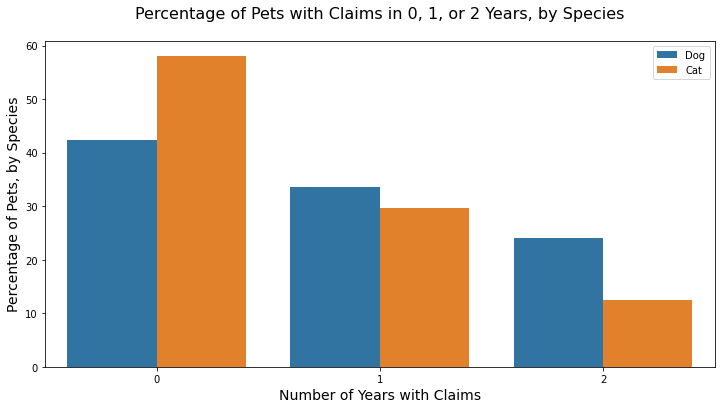

In [11]:
# Calculate the percentage of each species with claims in 0,1, or 2 years
claim_yr_counts = (pets.groupby(['Species'])['YrsWithClaims']
                     .value_counts(normalize=True)
                     .rename('Percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('YrsWithClaims'))

# Plot the data 
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
palette ={"Dog": "#1f77b4", "Cat": "#ff7f0e"}
hue_order = ['Dog', 'Cat']
sns.barplot(x="YrsWithClaims", y="Percentage", hue="Species", palette=palette, hue_order=hue_order, 
            data=claim_yr_counts)

# Plot the legend and display
plt.title("Percentage of Pets with Claims in 0, 1, or 2 Years, by Species", y=1.05, fontsize=16)
plt.xlabel("Number of Years with Claims", fontsize=14)
plt.ylabel("Percentage of Pets, by Species", fontsize=14)
plt.legend(loc='upper right')
plt.savefig('../figures/Claims-by-PolicyYear.png')
plt.show()

By plotting the percentages of each species with claims in zero, one, or both years, the results are easier to interpret. We see that cats are less likely to have claims overall and dogs are more likely to have claims in one or both policy years. In fact, dogs are almost twice as likely to have claims in both policy years than cats. 

### 3.5 How much does pet age matter when it comes to claims?

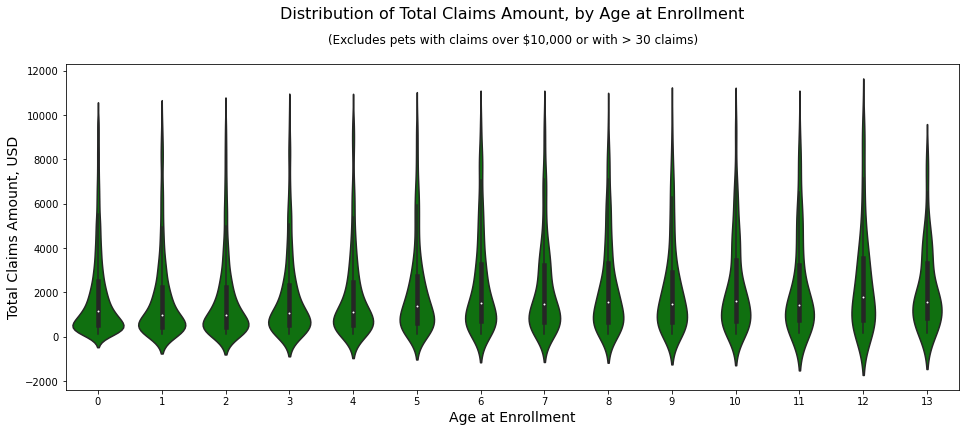

In [12]:
# Create a violin plot showing distribution of total claims based on year of enrollment
f, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.violinplot(x="AgeYr1", y="AmtClaimsTotal", data=claim_filter, color="Green")

# Add titles and display
plt.xlabel("Age at Enrollment", fontsize=14)
plt.ylabel("Total Claims Amount, USD", fontsize=14)
plt.title("Distribution of Total Claims Amount, by Age at Enrollment", y=1.12, fontsize=16)
plt.suptitle("(Excludes pets with claims over $10,000 or with > 30 claims)", y=0.95, x=0.513, fontsize=12)
plt.show()

At a high level, the violin plot shows the distribution of total claims amounts changing with age. As age increases, we see the spread of total claims amounts increasing as well. That said, the details of the distribution are difficult to make out in this view and it's tough to know if there is anything significant going on or not.

Let's try grouping pets by age-range to see if any interesting trends stand out.

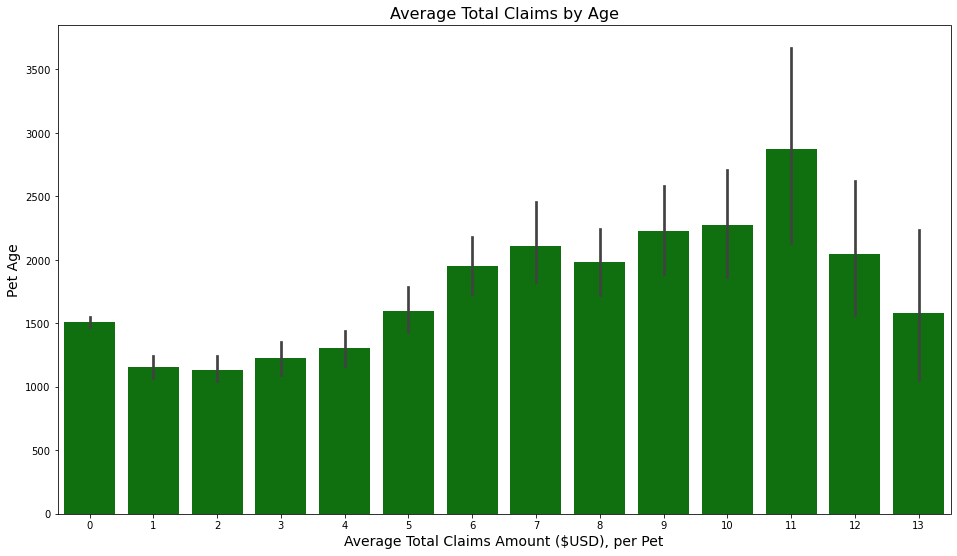

In [13]:
# Create horizontal barplot
plt.figure(figsize=(16,9))
sns.barplot(x="AgeYr1", y="AmtClaimsTotal", data=pets, color="green")
plt.xlabel("Average Total Claims Amount ($USD), per Pet", fontsize=14)
plt.ylabel("Pet Age", fontsize=14)
plt.title("Average Total Claims by Age", fontsize=16)
plt.show()

The bar plot provides a better perspective on the relationship between age and total claims amount. We can see that the average total claims amount tends to rise with age until approximately age 11. In addition, the error bars indicate the same increase in variability in the total claims amounts as pets age that we observed in the violin plot. Based on this result, it will be interesting to see how age factors in to our final customer segments.

### 3.6 Feature correlation
So far we've observed a few trends in the data related to species, claims and pet ages. Next, let's create a correlation matrix to see if any other strong relationships are visible in our data set.

First we'll filter down to a subset of our features that we are likely to include in our predictive model and then we can calculate correlations and plot the result in a heatmap. For this analysis, we'll break it out by species since we have seen evidence throughout that points to differences between cats and dogs.

In [14]:
# Filter data by species
cats = pets[pets.Species == 'Cat']
dogs = pets[pets.Species == 'Dog']

# Filter species dfs down the a subset of features
cols = ['Premium', 'Deductible', 'AgeYr1', 'MixedBreed', 'AmtClaimsTotal', 'NumClaimsTotal',
        'AvgClaimsTotal', 'MaxClaim']
cats_filtered = cats[cols]
dogs_filtered = dogs[cols]

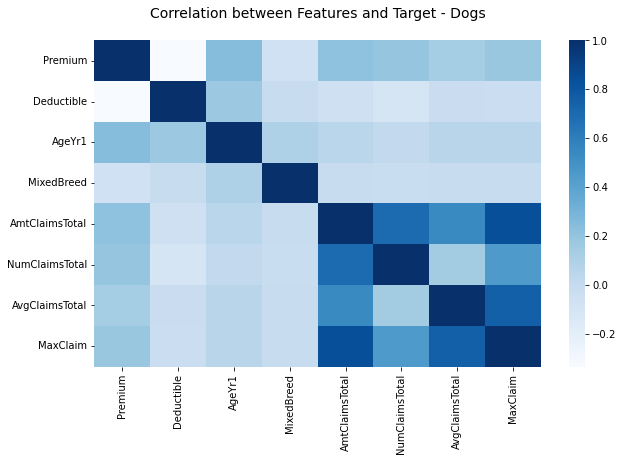

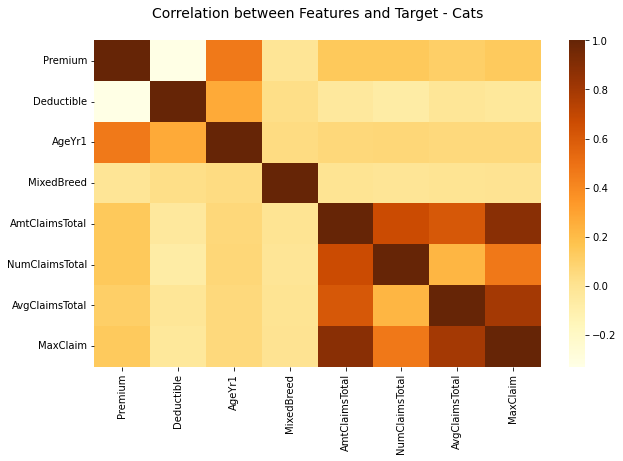

In [15]:
# Create correlation matrices
cats_corr = cats_filtered.corr()
dogs_corr = dogs_filtered.corr()

# Plot the corresponding heatmaps
plt.figure(figsize=(10,6))
_ = sns.heatmap(dogs_corr, cmap="Blues")
plt.title("Correlation between Features and Target - Dogs", y=1.05, fontsize=14)
plt.savefig('../figures/Feature-Correlation-Dogs.png')
plt.show()

plt.figure(figsize=(10,6))
_ = sns.heatmap(cats_corr, cmap="YlOrBr")
plt.title("Correlation between Features and Target - Cats", y=1.05, fontsize=14)
plt.savefig('../figures/Feature-Correlation-Cats.png')
plt.show()

## 4 Principle Components Analysis
The steps we'll follow for PCA include:

1. Initial feature prep and filtering of the data
2. Feature scaling
3. Fit the PCA transformation 
4. Apply the transformation to the data to create derived features

### 4.1 Data prep
Before we can start PCA, we need to do a bit of prep work on our data to remove or transform the categorical features (Species, Breed and EnrollPath). We've already observed that species is an important factor in our data so we need to maintain it. For now, we'll drop the other two categorical features and we can always pull them back in later if needed. In addition, we will also drop PetId since this is essentially a duplication of our index at this point and the feature doesn't tell us anything interesting about our pets.

We'll save the categorical features as a new dataframe so we can always relate back to it if required.

In [16]:
# Create a new dataframe with the categorical features
pets_categorical = pets[['PetId', 'Species', 'Breed', 'EnrollPath']]

# Save the new df to a file
pets_categorical.to_csv('../data/pets_categorical.csv')

In [17]:
# Convert Species to a binary column and merge back to main dataframe
species = pd.get_dummies(pets["Species"])
pets = pd.concat((species, pets), axis=1)

# Drop unnecessary columns
pets.drop(columns=["PetId", "Species", "Dog", "Breed", "EnrollPath"], axis=1, inplace=True)

# Rename Cat to Species and preview
pets.rename(columns={"Cat": "Species"}, inplace=True)
pets["Species"] = pets["Species"].astype(int)
pets.head().T

,0,1,2,3,4
Species,0.00,0.00,0.00,0.00,0.00
Premium,84.54,50.33,74.00,57.54,60.69
Deductible,200.00,500.00,500.00,500.00,700.00
AgeYr1,3.00,0.00,0.00,0.00,0.00
MixedBreed,0.00,0.00,1.00,0.00,0.00
AmtClaimsYr1,0.00,0.00,640.63,0.00,7212.25
AmtClaimsYr2,1242.00,0.00,1187.68,0.00,168.75
AvgClaimsYr1,621.00,0.00,237.54,0.00,168.75
AvgClaimsYr2,621.00,0.00,237.54,0.00,168.75
NumClaimsYr1,0.00,0.00,3.00,0.00,9.00


### 4.2 Feature Scaling

In [18]:
# Create a copy of the pets df and scale the features
pets_scale = pets.copy()
pets_scale_columns = pets_scale.columns
pets_scale = scale(pets_scale)

In [19]:
#Create a new dataframe from `pets_scale` using the column names we saved in `pets_scale_columns`
pets_scaled_df = pd.DataFrame(pets_scale, columns=pets_scale_columns)
pets_scaled_df.head()

,Species,Premium,Deductible,AgeYr1,MixedBreed,AmtClaimsYr1,AmtClaimsYr2,AvgClaimsYr1,AvgClaimsYr2,NumClaimsYr1,NumClaimsYr2,MaxClaim,AmtClaimsTotal,NumClaimsTotal,AvgClaimsTotal,YrsWithClaims
0,-0.437215,0.601961,-0.984882,0.637317,-0.586650,-0.367817,0.245274,0.893814,0.893814,-0.493220,0.149847,-0.028963,-0.071465,-0.182280,0.553071,0.289597
1,-0.437215,-0.400734,0.016632,-0.553989,-0.586650,-0.367817,-0.308511,-0.384552,-0.384552,-0.493220,-0.383892,-0.489539,-0.430211,-0.514368,-0.527518,-0.982239
2,-0.437215,0.293034,0.016632,-0.553989,1.704594,-0.072352,0.221054,0.104439,0.104439,0.398528,0.950456,-0.241123,0.097888,0.813984,-0.129840,1.561433
3,-0.437215,-0.189409,0.016632,-0.553989,-0.586650,-0.367817,-0.308511,-0.384552,-0.384552,-0.493220,-0.383892,-0.489539,-0.430211,-0.514368,-0.527518,-0.982239
4,-0.437215,-0.097082,0.684309,-0.553989,-0.586650,2.958539,-0.233268,-0.037170,-0.037170,2.182023,-0.117022,1.801088,1.701758,1.146072,0.756834,1.561433


### 4.3 Calculate the PCA Transformation

In [20]:
# Fit the PCA transformation using the scaled data
pets_pca = PCA().fit(pets_scale)

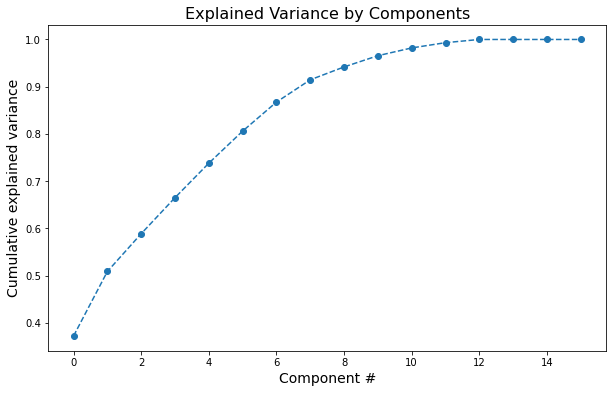

In [21]:
# Plot the cumulative variance ratio with number of components
plt.subplots(figsize=(10, 6))
plt.plot(pets_pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Component #', fontsize=14)
plt.ylabel('Cumulative explained variance', fontsize=14)
plt.title('Explained Variance by Components', fontsize=16);

Based on the plot above, we see that the first 5 components explain over 80% of the variance and the first 7 components explain over 90% of the variance in the data.

### 4.4 Apply the transformation to the data 

In [22]:
# Apply the transformation to the data
pets_pca_x = pets_pca.transform(pets_scale)

# View the shape
pets_pca_x.shape

(50000, 16)

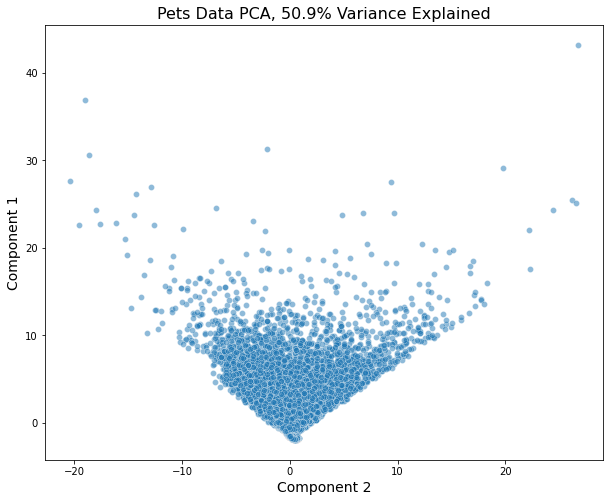

In [23]:
# Isolate the top two components from PCA
x = pets_pca_x[:, 1]
y = pets_pca_x[:, 0]

# Plot a scatterplot of the top two components
pc_var = 100 * pets_pca.explained_variance_ratio_.cumsum()[1]
plt.figure(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=pets_pca_x, alpha=0.5)
plt.xlabel('Component 2', fontsize=14)
plt.ylabel('Component 1', fontsize=14)
plt.title(f'Pets Data PCA, {pc_var:.1f}% Variance Explained', fontsize=16)
plt.show()

# UPDATE

Include some interpretation of the above plot

### 4.5 Perform PCA with the chosen number of components

In [24]:
# Perform PCA with chosen number of components (i.e. 5)
pca = PCA(n_components = 5)

# Fit the model to the data with the chosen number of components
pca.fit(pets_scale)

PCA(n_components=5)

In [25]:
# Transform the data and capture the scores
scores_pca = pca.transform(pets_scale)

## 5 Determine Number of Clusters using K-Means

### 5.1 Fit K-means using the transformed data from PCA

In [26]:
# Generate list for 'Within Cluster Sum of Squares' for each cluster value
wcss = []

for i in range(1,11):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

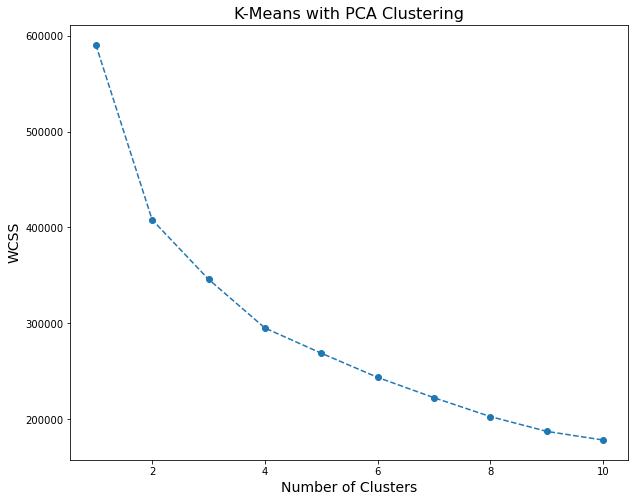

In [27]:
# Plot the result
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters", fontsize=14)
plt.ylabel("WCSS", fontsize=14)
plt.title("K-Means with PCA Clustering", fontsize=16)
plt.show()

From the graph above, we can use the line to determine the number of clusters we’d like to keep by using the  Elbow-method. We can see that there is an 'elbow' in the graph at the point where the steep decline starts to flatten out. In our case, this looks to be at the 3 or 4 cluster mark. 

This observation matches up well with the initial instructions from Marketing that they expected to see 3-4 clusters in the data. We'll start with 3 as our number of clusters to keep things simpler for now and then later we can adjust to 4 if needed depending on the results of our analysis.

### 5.2 Implement K-Means with our chosen number of clusters

In [28]:
# Implement k-means with our chosen number of clusters and the same parameters as earlier
kmeans_pca = KMeans(n_clusters=3, init='k-means++', random_state=42)

# Fit our data with the kmeans pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

### 5.3 Add PCA components and K-Means clusters as new features

In [29]:
# Create new df with original features + PCA results
pets_pca_kmeans = pd.concat([pets.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
pets_pca_kmeans.columns.values[-5: ] = ["Component_1", "Component_2", "Component_3", "Component_4", "Component_5"]

# Add results of K-Means clustering as a new feature
pets_pca_kmeans["Segment"] = kmeans_pca.labels_

# Preview the result
pets_pca_kmeans.head().T

,0,1,2,3,4
Species,0.000000,0.000000,0.000000,0.000000,0.000000
Premium,84.540000,50.330000,74.000000,57.540000,60.690000
Deductible,200.000000,500.000000,500.000000,500.000000,700.000000
AgeYr1,3.000000,0.000000,0.000000,0.000000,0.000000
MixedBreed,0.000000,0.000000,1.000000,0.000000,0.000000
AmtClaimsYr1,0.000000,0.000000,640.630000,0.000000,7212.250000
AmtClaimsYr2,1242.000000,0.000000,1187.680000,0.000000,168.750000
AvgClaimsYr1,621.000000,0.000000,237.540000,0.000000,168.750000
AvgClaimsYr2,621.000000,0.000000,237.540000,0.000000,168.750000
NumClaimsYr1,0.000000,0.000000,3.000000,0.000000,9.000000


In [30]:
# Add names for each of our segments
pets_pca_kmeans["Segment"] = pets_pca_kmeans["Segment"].map({0: 'first', 1: 'second', 2: 'third'})

# View count of each customer segment
pets_pca_kmeans["Segment"].value_counts()

first     34596
second    13151
third      2253
Name: Segment, dtype: int64

### 5.4 Visualize the segments

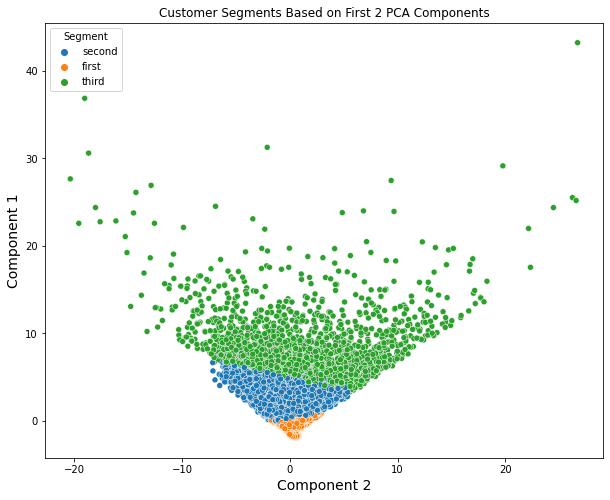

In [31]:
# Set the values for x and y based on the first and second components
x = pets_pca_kmeans["Component_2"]
y = pets_pca_kmeans["Component_1"]

plt.figure(figsize=(10,8))
sns.scatterplot(x=x, y=y, data=pets_pca_kmeans, hue="Segment")
plt.xlabel("Component 2", fontsize=14)
plt.ylabel("Component 1", fontsize=14)
plt.title("Customer Segments Based on First 2 PCA Components")
plt.show()

# UPDATE

Include some interpretation of the above result

## 6 Summary and Conclusions

# UPDATE


### 6.1 Data Cleanup and Export

In [32]:
# Write final df to csv 
pets_pca_kmeans.to_csv('../data/pets_pca_kmeans.csv')